In [49]:
import folium
import pandas as pd
import numpy as np
import os
from geopy.geocoders import Nominatim
import geocoder
import matplotlib.pyplot as plt
import json
from folium import plugins
import branca.colormap as cm
from tqdm import tqdm_notebook
plt.style.use('ggplot')

In [2]:
def get_elevation(lat,lon):
    try:
        return geocoder.google([lat, lon], method='elevation', key=os.environ['GOOGLE_API_KEY']).meters
    except:
        return np.NaN

In [3]:
def read_csv(filename):
    df = pd.read_csv(filename)
    NewLap_idx = df[df.Time == 'New Lap'].index.values
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df.dropna(how='any',axis=0, subset=['Time'], inplace=True)
    for lab in ['LongitudeDegrees', 'LatitudeDegrees', 'AltitudeMeters', 'heartratebpm/value']:
        df[lab] = df[lab].interpolate()
    df['dist'] = \
        haversine_np(df.LongitudeDegrees.shift(), df.LatitudeDegrees.shift(),
                     df.loc[1:, 'LongitudeDegrees'], df.loc[1:, 'LatitudeDegrees'])
    df['cum_dis'] = df.dist.cumsum()
    df['DeltaTime'] = (df.Time - df.Time.shift()).dt.total_seconds()
    df['Speed'] = df.apply(lambda x: x['dist']/float(x['DeltaTime'])*3600.0 if x['DeltaTime'] > 0.5 else np.NaN, axis=1)
    df['Speed'] = df.apply(lambda x: x['Speed'] if x['Speed'] < 20 else np.NaN, axis=1)
    df['DeltaAltitude'] = df.AltitudeMeters - df.AltitudeMeters.shift()
    df.to_csv('output/csv/' + os.path.basename(filename))
    return df, NewLap_idx

In [4]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [4]:
#path = 'data/csv/'
path = 'output/csv'
geolocator = Nominatim()
allFiles = os.listdir(path)
frame = pd.DataFrame(columns=('Date', 'Filename', 'Kilometers', 'Speed', 'Time', 'Climb', 'Lat', 'Long', 'Adress'))
dict_df = dict()
#dict_newlap = dict()
for i, file in tqdm_notebook(enumerate(allFiles)):
    df = pd.read_csv('output/csv/' + file, index_col=0, parse_dates=['Time'])
    #df, newlap = read_csv(path + file)
    dict_df[df['Time'][0].strftime("%Y-%m-%d")] = df
    location = geolocator.reverse(str(df.LatitudeDegrees.mean()) + "," + str(df.LongitudeDegrees.mean()))[0]
    frame.loc[i] = [df['Time'][0], file, df.cum_dis.max(), df.Speed.mean(), df.DeltaTime.sum()/60,
                    df['DeltaAltitude'][df['DeltaAltitude'] > 0].sum(),
                    df.LatitudeDegrees.mean(), df.LongitudeDegrees.mean(), location]

### Session manual add

In [5]:
frame.loc[frame[frame['Filename'] == '2017-09-01T05_07_50Z_PT50M7S_Running.csv'].index,'Speed'] = 10.9
frame.loc[frame[frame['Filename'] == '2017-09-01T05_07_50Z_PT50M7S_Running.csv'].index,'Kilometers'] = 8.09
frame.loc[frame[frame['Filename'] == '2017-09-01T05_07_50Z_PT50M7S_Running.csv'].index,'Time'] = 44.5
frame.loc[frame[frame['Filename'] == '2017-09-01T05_07_50Z_PT50M7S_Running.csv'].index,'Climb'] = 130

In [6]:
frame.sort_values('Date', ascending=False)

,Date,Filename,Kilometers,Speed,Time,Climb,Lat,Long,Adress
31,2017-09-28 17:31:41.836,2017-09-28T17_32_18Z_PT40M33S_Running.csv,7.643801,11.602275,41.166867,742.000,48.822395,2.338011,"Le Petit Train, Allée du Bardo, Montsouris, Pa..."
1,2017-09-26 17:29:38.784,2017-09-26T17_29_38Z_PT42M55S_Running.csv,8.761183,11.979408,42.932483,890.000,48.822418,2.337851,"Le Petit Train, Allée du Bardo, Montsouris, Pa..."
53,2017-09-23 09:23:27.402,2017-09-23T09_23_58Z_PT1H59M11S_Running.csv,21.848359,11.175643,119.718800,2166.000,48.780568,2.292178,"Avenue Charles Péguy, Sceaux, Antony, Hauts-de..."
45,2017-09-21 16:34:23.641,2017-09-21T16_34_23Z_PT45M38S_Running.csv,10.592581,11.908545,45.635200,1048.000,48.846442,2.335671,"Jardin du Luxembourg, Cour de Jonction, Odéon,..."
41,2017-09-19 16:36:08.981,2017-09-19T16_36_08Z_PT44M32S_Running.csv,9.041560,12.643044,44.544367,897.000,48.846427,2.335698,"Jardin du Luxembourg, Cour de Jonction, Odéon,..."
5,2017-09-16 07:17:00.070,2017-09-16T07_17_00Z_PT1H30M8S_Running.csv,17.096634,11.390383,90.146483,1854.000,48.784790,2.291165,"Rue François Moreau, Fontenay-aux-Roses, Anton..."
6,2017-09-14 17:23:15.896,"2017-09-14T16_20_43Z_PT1H42M47S_Biking,Running...",8.048995,11.910404,36.919733,848.000,48.822385,2.338098,"Le Petit Train, Allée du Bardo, Montsouris, Pa..."
37,2017-09-12 16:59:14.957,2017-09-12T16_59_14Z_PT51M33S_Running.csv,9.248593,12.426092,51.559717,909.000,48.846306,2.335477,"Anne de Beaujeu, Cour de la Présidence, Odéon,..."
50,2017-09-09 08:27:03.960,2017-09-09T08_27_03Z_PT1H55M7S_Running.csv,21.728122,11.392283,115.132050,2317.000,48.779607,2.291531,"Fontenay-Houdan, Rue de Fontenay, Sceaux, Anto..."
24,2017-09-07 17:01:55.000,RunnerUp_0058.csv,8.679763,12.729851,41.800000,853.000,48.846475,2.335826,"Jardin du Luxembourg, Cour de Jonction, Odéon,..."


In [7]:
recent_frame = frame[frame['Date'] > pd.datetime(2017, 6, 1)]

# Kilometers by date

In [81]:
recent_frame = recent_frame.assign(Month=recent_frame['Date'].dt.month, Week=recent_frame['Date'].dt.week, 
                                   Weekday=recent_frame['Date'].dt.weekday)

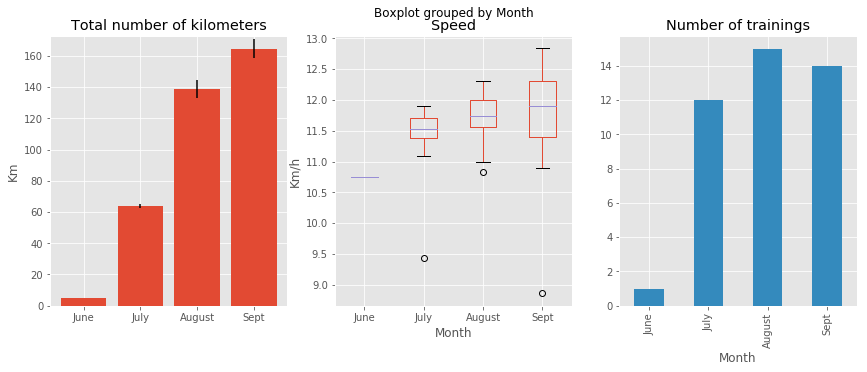

In [78]:
months = ['June', 'July', 'August', 'Sept']
fig, axr = plt.subplots(1,3, figsize=(14,5))
axr[0].bar(recent_frame.groupby(recent_frame.Date.dt.month).agg({'Kilometers': 'sum'}).index, 
        recent_frame.groupby(recent_frame.Date.dt.month).agg({'Kilometers': 'sum'}).values,
        yerr=recent_frame.groupby(recent_frame.Date.dt.month).agg({'Kilometers': 'std'}).values,
        tick_label=months, label='Number of kilometers')
axr[0].set_title('Total number of kilometers')
axr[0].set_ylabel('Km')
recent_frame.boxplot(['Speed'], by='Month', ax=axr[1])
axr[1].set_xticklabels(months)
axr[1].set_ylabel('Km/h')
recent_frame.groupby('Month')['Speed'].count().plot.bar(ax=axr[2], color='C1')
axr[2].set_xticklabels(months)
axr[2].set_title('Number of trainings')
plt.show()

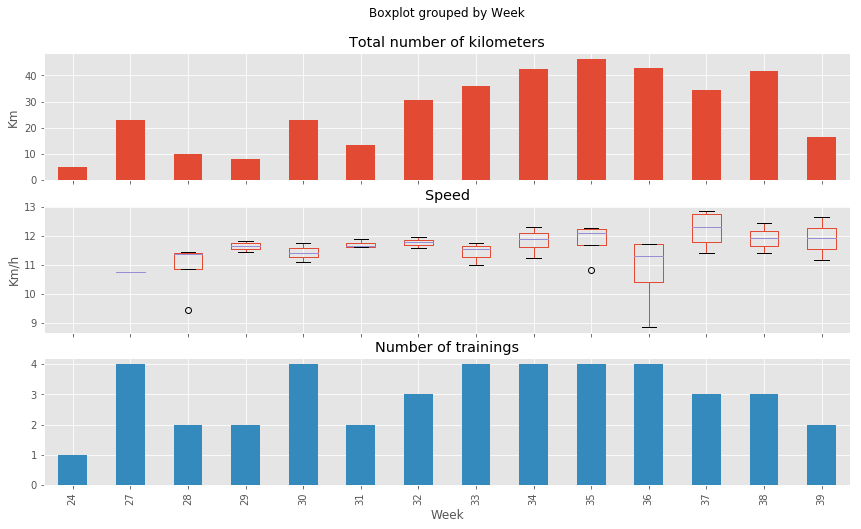

In [93]:
months = ['June', 'July', 'August', 'Sept']
fig, axr = plt.subplots(3, figsize=(14,8), sharex=True)
recent_frame.groupby('Week')['Kilometers'].sum().plot.bar(ax=axr[0])
axr[0].set_title('Total number of kilometers')
axr[0].set_ylabel('Km')
recent_frame.boxplot(['Speed'], by='Week', ax=axr[1])
axr[1].set_ylabel('Km/h')
recent_frame.groupby('Week')['Speed'].count().plot.bar(ax=axr[2], color='C1')
axr[2].set_title('Number of trainings')
plt.show()

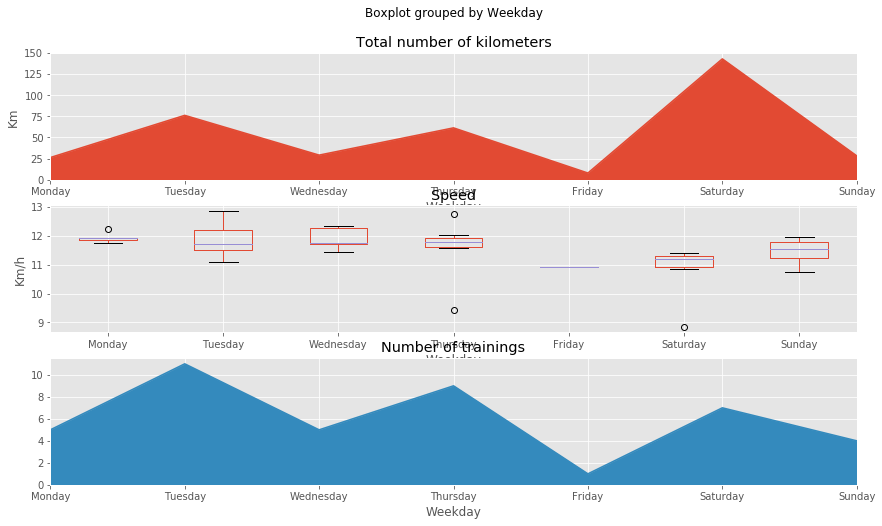

In [118]:
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, axr = plt.subplots(3, figsize=(14,8))
recent_frame.groupby('Weekday')['Kilometers'].sum().plot.area(ax=axr[0])
axr[0].set_title('Total number of kilometers')
axr[0].set_ylabel('Km')
axr[0].set_xticklabels(weekdays)
recent_frame.boxplot(['Speed'], by='Weekday', ax=axr[1])
axr[1].set_ylabel('Km/h')
axr[1].set_xticklabels(weekdays)
recent_frame.groupby('Weekday')['Speed'].count().plot.area(ax=axr[2], color='C1')
axr[2].set_title('Number of trainings')
axr[2].set_xticklabels(weekdays)
plt.show()

# Marathon prediction

In [119]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [120]:
recent_frame[['Kilometers', 'Climb']].values.shape

(42, 2)

In [121]:
np.stack([recent_frame.index.values,recent_frame['Time'].values, recent_frame['Climb'].values], axis=1).shape

(42, 3)

In [122]:
#X_train = np.stack([recent_frame.index.values, recent_frame['Kilometers'].values, recent_frame['Climb'].values ], axis=1)
X_train = recent_frame[['Kilometers','Climb']].values
y_train = recent_frame['Time']
X_test = np.array([42.195, 400]).reshape(1,-1)

In [123]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print('Distance: {} Km, Speed: {} Km/h, Time: {} hours \n'.format(X_test[0][0], X_test[0][0]/float(y_pred[0]/60), y_pred[0]/60))

Distance: 42.195 Km, Speed: 10.563563454086022 Km/h, Time: 3.99439073598586 hours 



In [124]:
Dis = 10
Climb = 400
val = np.array([Dis, Climb]).reshape(1,-1)
print(Dis/(regr.predict(val)/60))
#print('Distance: {} Km, Speed: {} Km/h, Time: {} hours \n'.format(X_test[0][1], X_test[0][1]/float(y_pred[0]/60), y_pred[0]/60))

[ 11.210528]


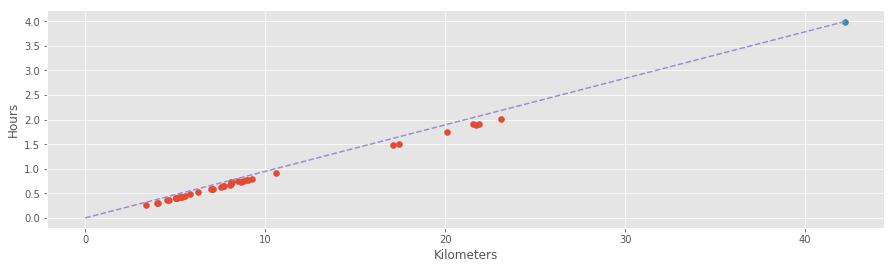

In [221]:
plt.figure(figsize=(15,4))
plt.scatter(X_train[:,0], regr.predict(X_train)/60)
plt.scatter(X_test[:,0], y_pred/60)
plt.plot([0, X_test[:,0]], [0, y_pred/60], '--', color='C2')
plt.ylabel('Hours')
plt.xlabel('Kilometers')
plt.show()

# Speed by training

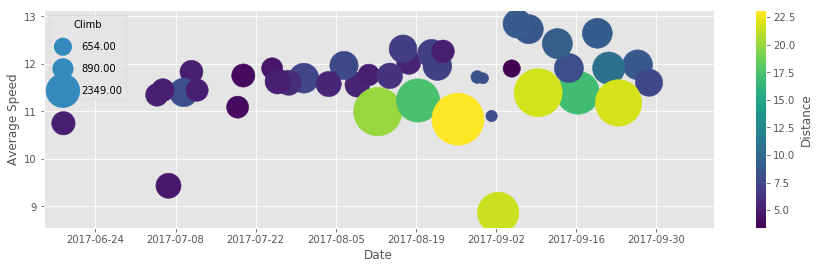

In [223]:
plt.figure(figsize=(15,4))
ax = plt.axes()
ax.set_xlim([pd.datetime(2017,6,15),pd.datetime(2017,10,10)])

legend_sizes = np.sort(recent_frame.Climb)[::len(recent_frame.Climb)//4][-3:]
# get the indices for each of the legend sizes
indices = [np.where(recent_frame.Climb==v)[0][0] for v in legend_sizes]
# plot each point again, and its value as a label
for i in indices:
    plt.scatter(x=recent_frame.Date.iloc[i], y=recent_frame.Speed.iloc[i], c=recent_frame.Kilometers.iloc[i], s=recent_frame.Climb.iloc[i]/2,
                  vmin=0,vmax=1,edgecolors='none',
                  label='{:.2f}'.format(recent_frame.Climb.iloc[i]))
# add the legend
plt.scatter(x=recent_frame.Date.values, y=recent_frame.Speed, c=recent_frame.Kilometers, s=recent_frame.Climb, label=None)
#plt.scatter(x=pd.to_datetime('2017-10-09', format='%Y-%m-%d'), y=X_test[0][0]/float(y_pred[0]/60), c=X_test[0][0], s=X_test[0][1], linewidth=3)
plt.plot(X_test[0][0]/float(y_pred[0]/60))
plt.colorbar(label='Distance')
plt.xlabel('Date')
plt.ylabel('Average Speed')
plt.legend(scatterpoints=1, title='Climb', labelspacing=1.2)
plt.show()

In [261]:
list_speed_bubble = list()
list_speed_prediction = list()
list_linear_regression = list()
for k,val in recent_frame.iterrows():
    list_speed_bubble.append({'x': val['Date'].strftime("%Y-%m-%d"), 'y': np.round(val['Speed'],2), 'r': np.round(val['Kilometers'],2)})
    to_predict = val[['Kilometers', 'Climb']].values.reshape(1,-1)
    list_linear_regression.append({'x': np.round(val['Kilometers'],2), 'y': np.round(regr.predict(to_predict)[0]/60,2)})
    #list_speed_prediction.append({'x': val['Date'].strftime("%Y-%m-%d"), 'y': np.round(val['Kilometers']/(regr.predict(to_predict)[0]/60),2), 'r': np.round(val['Kilometers'],2)})

list_speed_bubble.append({'x': '2017-10-08', 'y': np.round(X_test[0][0]/float(y_pred[0]/60),2), 'r': np.round(X_test[0][0],2)})
list_speed_prediction.append({'x': '2017-10-08', 'y': np.round(X_test[0][0]/float(y_pred[0]/60),2), 'r': np.round(X_test[0][0],2)})

In [262]:
to_predict = np.reshape([0,40], (1,-1))
regr.predict(to_predict)[0]/60
#list_speed_predi

-0.048497971407600253

## Export json

In [263]:
df_steps = pd.concat([recent_frame.Date.dt.strftime("%s"), recent_frame.Kilometers.round(1)], axis=1)

dic_steps = dict()
for k,x in df_steps.iterrows():
    dic_steps[x['Date']] = x['Kilometers']


In [264]:
with open('output/marathon.json', 'w') as outfile:
    json.dump({'weekday': {'Kilometers': [i[0] for i in recent_frame.groupby(recent_frame.Date.dt.weekday).agg({'Kilometers': 'mean'}).round(1).values.tolist()],
                           'Speed': [i[0] for i in recent_frame.groupby(recent_frame.Date.dt.weekday).agg({'Speed': 'mean'}).round(1).values.tolist()],
                           'Trains': [i[0] for i in recent_frame.groupby(recent_frame.Date.dt.weekday).agg({'Kilometers': 'count'}).round(1).values.tolist()],
                           'index' : weekdays
                          },
               'week': {'index' : [float(i) for i in recent_frame.groupby(recent_frame.Date.dt.week).agg({'Kilometers': 'count'}).index.tolist()],
                       'Kilometers': [float(i[0]) for i in recent_frame.groupby(recent_frame.Date.dt.week).agg({'Kilometers': 'sum'}).round(1).values],
                       'Speed': [float(i[0]) for i in recent_frame.groupby(recent_frame.Date.dt.week).agg({'Speed': 'mean'}).round(1).values],
                       'Trains': [float(i[0]) for i in recent_frame.groupby(recent_frame.Date.dt.week).agg({'Kilometers': 'count'}).round(1).values]
                       },
               'month': {'Kilometers' : [float(i) for i in recent_frame.groupby(recent_frame.Date.dt.month).agg({'Kilometers': 'sum'}).round(1).values],
                         'Speed' : [float(i) for i in recent_frame.groupby(recent_frame.Date.dt.month).agg({'Speed': 'mean'}).round(1).values],
                         'Trains' : [float(i) for i in recent_frame.groupby(recent_frame.Date.dt.month).agg({'Kilometers': 'count'}).round(1).values],
                         'index' : months
               },
               'heatmap_km': dic_steps,
               'bubble_speed': {'real': list_speed_bubble, 'predict': sorted(list_speed_prediction, key=lambda x : x['x'], reverse=False)},
               'linear_reg': {'points': list_linear_regression, 'line': [{'x': 0, 'y': -0.04}, {'x':  X_test[:,0][0], 'y' : np.round((y_pred/60)[0], 2)}]}
               #'leaflet': [[i[0], i[1], 1] for i in [[float(v.Lat), float(v.Long)] for k,v in recent_frame.iterrows()]],
              }, outfile, indent=1)

# Heatmap folium

In [254]:
mean_lat = np.mean([i[0] for i in [[float(v.Lat), float(v.Long)] for k,v in recent_frame.iterrows()]])
mean_long = np.mean([i[1] for i in [[float(v.Lat), float(v.Long)] for k,v in recent_frame.iterrows()]])
m = folium.Map(location=[mean_lat, mean_long ], zoom_start=11, tiles='OpenStreetMap')
m.add_child(plugins.HeatMap(recent_frame[['Lat','Long']].values, radius = 20), name='Training location')
colormap = cm.LinearColormap(['blue', 'green',  'yellow', 'orange', 'red'],  index=[0, 0.25, 0.5, 0.75, 1.0]).scale(0,20)
colormap.caption = 'Number of trainings'
m.add_child(colormap)
m